# Application of VGG16 (Transfer Learning)



## 1. Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import cv2

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses
from keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import set_random_seed
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
# Setting the seed
seed = 42
set_random_seed(seed)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
folder_path = "/content/drive/My Drive/Colab Notebooks/Research Project/Data/Cropped_faces"

Mounted at /content/drive


In [ ]:
# Creating training and validation sets...

list_ds = tf.data.Dataset.list_files(folder_path + "/*")
# Total number of files
file_count = len(list(list_ds))

# Define the split ratio
size = int(0.8 * file_count)  # 80% for training

# Shuffle the dataset before splitting
list_ds = list_ds.shuffle(buffer_size=file_count)

# Split into training and validation datasets
train_list_ds = list_ds.take(size)  # First 80% for training
val_list_ds = list_ds.skip(size)    # Remaining 20% for validation

# for element in list_ds.as_numpy_iterator():
#   print(element)
#   break

In [ ]:
def read_image(fname):
  #print(fname)                             # e.g. b'/content/drive/My Drive/Colab Notebooks/Research Project/Data/Cropped_faces/28_0_1_20170117202354238.jpg.chip.jpg'
  parts = tf.strings.split(fname, os.sep)
  file_name = parts[-1]                      # e.g. 28_0_1_20170117202354238.jpg.chip.jpg
  multiple_labels = tf.strings.split(file_name, '_')
  gender_label = multiple_labels[:-1][1]     # e.g. 0
  label = tf.strings.to_number(gender_label)
  image = tf.io.read_file(fname)        # This reads the image file as a raw byte string
  image = tf.io.decode_jpeg(image)      # This decodes the raw byte string into a tensor (image array-RGB) using JPEG format.
  return image, label

Gender label: 0.0
(200, 200, 3)


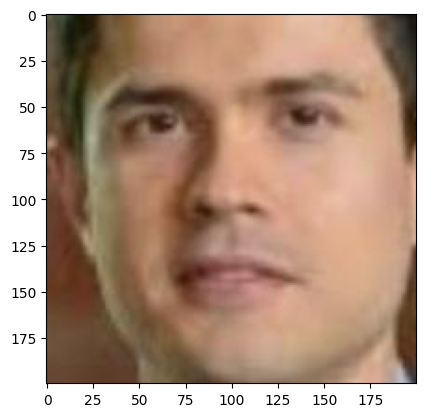

In [ ]:
for element in list_ds.as_numpy_iterator():
  img, lab = read_image(element)
  plt.figure()
  plt.imshow(img)
  print(f'Gender label: {lab.numpy()}')
  print(img.shape)
  break

In [ ]:
def preprocess_image(image, label, augment=True):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)  #converts the image's pixel values to the [0,1] range
  #image = tf.image.resize(image, [size, size])

  if augment:
    # Apply augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    image = tf.image.random_rotation(image, angles=40 * (3.14159 / 180.0))  # Rotate up to 40 degrees
  return image, label

In [ ]:
batch_size = 128
train_ds = (
    train_list_ds
    .map(read_image, num_parallel_calls = tf.data.AUTOTUNE) # Parallel mapping
    .batch(batch_size)
    .cache()
    .map(preprocess_image, num_parallel_calls = tf.data.AUTOTUNE) # Vectorisation
    .prefetch(tf.data.AUTOTUNE)
)

# Validation images are only parsed with the processing function
val_ds = (
    val_list_ds
    .map(read_image, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .map(preprocess_image, num_parallel_calls = tf.data.AUTOTUNE) # Vectorisation
    .prefetch(tf.data.AUTOTUNE)
)

## 2. Building a CNN using Transfer Learning on VGG16
Input image shape: (200, 200, 3)

Loading the VGG16 model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Freezing the block1 in VGG16 model.
for layer in base_model.layers[:16]:
  layer.trainable = False

print("Base model:")
base_model.summary()

cnt =1
for layer in base_model.layers:
  print(f'{cnt}: {layer}')
  cnt = cnt+1

Base model:


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 200, 200, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 200, 200, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 100, 100, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 100, 100, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 50, 50, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 50, 50, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 50, 50, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 25, 25, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 25, 25, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 25, 25, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 25, 25, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

1: <InputLayer name=input_layer_6, built=True>
2: <Conv2D name=block1_conv1, built=True>
3: <Conv2D name=block1_conv2, built=True>
4: <MaxPooling2D name=block1_pool, built=True>
5: <Conv2D name=block2_conv1, built=True>
6: <Conv2D name=block2_conv2, built=True>
7: <MaxPooling2D name=block2_pool, built=True>
8: <Conv2D name=block3_conv1, built=True>
9: <Conv2D name=block3_conv2, built=True>
10: <Conv2D name=block3_conv3, built=True>
11: <MaxPooling2D name=block3_pool, built=True>
12: <Conv2D name=block4_conv1, built=True>
13: <Conv2D name=block4_conv2, built=True>
14: <Conv2D name=block4_conv3, built=True>
15: <MaxPooling2D name=block4_pool, built=True>
16: <Conv2D name=block5_conv1, built=True>
17: <Conv2D name=block5_conv2, built=True>
18: <Conv2D name=block5_conv3, built=True>
19: <MaxPooling2D name=block5_pool, built=True>


Modifying the VGG16 model

In [ ]:
seed = 42
set_random_seed(seed)
np.random.seed(42)

#Here we can add our base model to our own.
num_classes = 2
x_in = base_model.get_layer('block5_pool').output
x_in = layers.Reshape((-1,))(x_in)  # Reshape to a single vector
#x = layers.Flatten()(x_in)
x = layers.Dense(128, activation='relu')(x_in)
pred = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs = base_model.input, outputs = pred, name='model')

print("My VGG model:")
model.summary()

My VGG model:


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 200, 200, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 200, 200, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 100, 100, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 100, 100, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 50, 50, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 50, 50, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 50, 50, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 25, 25, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 25, 25, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 25, 25, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 25, 25, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,074,370 (65.13 MB)

 Trainable params: 2,359,682 (9.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# import cv2 as cv
# img_size = 64
# X_train = np.array([cv.resize(x, (img_size, img_size), interpolation=cv.INTER_AREA) for x in x_train])
# X_val = np.array([cv.resize(x, (img_size, img_size), interpolation=cv.INTER_AREA) for x in x_val])
# X_test = np.array([cv.resize(x, (img_size, img_size), interpolation=cv.INTER_AREA) for x in x_test])

# X_train = X_train.astype('float32')/255
# X_test = X_test.astype('float32')/255
# X_val = X_val.astype('float32')/255

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
# My model’s last layer has a softmax activation, thus from_logits=False

mc_callback = ModelCheckpoint('./weights.keras', monitor='val_accuracy', save_best_only=True, mode='max')
def scheduler(epoch, lr):
    if epoch < 6:
        return lr
    else:
        return lr * np.exp(-0.01)

lr_callback = LearningRateScheduler(scheduler)

#history = model.fit(aug.flow(X_train, y_train), epochs=15, batch_size=64, validation_data=(X_val, y_val), callbacks=[mc_callback, lr_callback])


In [ ]:
history = model.fit(train_ds, epochs=10,
                    batch_size=batch_size, validation_data=val_ds,
                    callbacks=[mc_callback, lr_callback])  #batch_size=128

Epoch 1/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 4246s 28s/step - accuracy: 0.7140 - loss: 0.5479 - val_accuracy: 0.8605 - val_loss: 0.3417 - learning_rate: 1.0000e-04
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 89s 595ms/step - accuracy: 0.8669 - loss: 0.3179 - val_accuracy: 0.8866 - val_loss: 0.2961 - learning_rate: 1.0000e-04
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 143s 599ms/step - accuracy: 0.8870 - loss: 0.2757 - val_accuracy: 0.8959 - val_loss: 0.2693 - learning_rate: 1.0000e-04
Epoch 4/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 138s 570ms/step - accuracy: 0.8997 - loss: 0.2501 - val_accuracy: 0.9054 - val_loss: 0.2498 - learning_rate: 1.0000e-04
Epoch 5/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 84s 565ms/step - accuracy: 0.9097 - loss: 0.2310 - val_accuracy: 0.9102 - val_loss: 0.2348 - learning_rate: 1.0000e-04
Epoch 6/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 88s 592ms/step - accuracy: 0.9161 - loss: 0.2155 - val_accuracy: 0.9164 - val_loss: 0.2221 - learning_rate: 1.0000e-04
Epoch 7/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 85s 

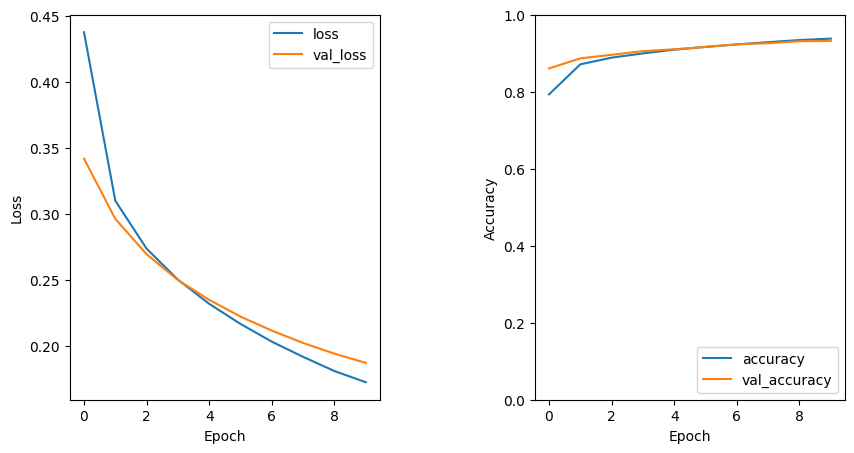

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
plt.subplots_adjust(hspace=0.1, wspace=0.5)

axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label = 'val_loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='upper right')

axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label = 'val_accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 1])
axs[1].legend(loc='lower right')

In [ ]:
print(base_model.get_layer('block5_pool').output.shape)

(None, 6, 6, 512)


In [ ]:
for image, label in train_ds.take(1):
  print(image.shape)
  print(label)

(128, 200, 200, 3)
tf.Tensor(
[0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1.
 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0.], shape=(128,), dtype=float32)


In [ ]:
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras import layers, models

# # Base model: VGG16 with pre-trained weights and no top (fully connected layers)
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# # Freeze the base model (to avoid retraining)
# base_model.trainable = False

# # Add custom layers on top of the base model
# model = models.Sequential([
#   base_model,
#   layers.Flatten(),  # Flatten the output from VGG16
#   layers.Dense(128, activation='relu'),  # Add fully connected layers
#   layers.Dense(num_classes, activation='softmax')  # Final output layer with softmax for classification
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Display the model summary to check the shapes
# model.summary()
